In [1]:
import os, sys, time, pickle, glob
from pathlib import Path

# numpy to SITK conversion
import torch
import numpy     as np
import SimpleITK as sitk

# meshio for 3DSlicer segm obj
import meshio


# segmentation
from scipy.spatial   import Delaunay
    

# hardware stats
import GPUtil as GPU

# plot
from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.viz import *

In [2]:
root = "/home/gologors/data/"

# Load filenames

In [4]:
# Get Labels
with open(root + 'pitmri/' + 'loni_filenames.pkl', 'rb') as f: 
    loni_filenames = pickle.load(f)
    
with open(root + 'pitmri/' + 'pit_filenames.pkl', 'rb') as f: 
    pit_filenames = pickle.load(f)
    
all_filenames = loni_filenames + pit_filenames

In [5]:
im_fn, lbl_fn = all_filenames[-5]

print(im_fn, "\n", lbl_fn)

/home/gologors/data/anno/1.2.840.114350.2.277.2.798268.2.285712891.1/1.3.46.670589.11.21104.5.0.5016.2017042512153942773/1.3.46.670589.11.21104.5.0.5016.2017042512153942773_COR_T1_Dyn_SENSE_20170425114706_1001_t119737.nii.gz 
 /home/gologors/data/anno/1.2.840.114350.2.277.2.798268.2.285712891.1/1.3.46.670589.11.21104.5.0.5016.2017042512153942773/Segmentation.obj


In [6]:
im_fns = sorted([a for a,b in all_filenames])

for a in im_fns:
    print(os.path.basename(a))

2.25.184249200549587298191910596089011880848_t1_se_r_cor_20160926211853_7.nii.gz
1.3.46.670589.11.37169.5.0.7164.2016102004110442509_COR_T1_CLEAR_20161020033557_701.nii.gz
1.3.46.670589.11.37169.5.0.7164.2016102005322626072_COR_T1_CLEAR_20161020045705_701.nii.gz
1.3.46.670589.11.70769.5.0.6828.2016112311204114626_+COR_T1_THIN_SENSE_20161123104913_901.nii.gz
2.25.128099500521260683799022260026606955306_+Cor_T1_THIN_20161018100638_13.nii.gz
1.3.46.670589.11.37169.5.0.7064.2016102904242870274_COR_T1_CLEAR_20161029040301_701.nii.gz
1.3.46.670589.11.37169.5.0.8820.2016110101521229038_COR_T1_CLEAR_20161101012852_701.nii.gz
2.25.261945188120165157234217181512902374008_COR_T1_SE_20160919105232_3.nii.gz
1.3.46.670589.11.37169.5.0.3436.2016110300230654926_COR_T1_CLEAR_20161103000404_701.nii.gz
1.3.46.670589.11.42053.5.0.4772.2016110301201227714_COR_T1_CLEAR_20161103010128_801.nii.gz
1.3.46.670589.11.42001.5.0.5556.2016110816312576639_COR_T1_CLEAR_20161108160627_801.nii.gz
2.25.146054966958629375

# Segm Obj -> SITK

In [7]:
# 1. Get affine matrix in SITK
# https://niftynet.readthedocs.io/en/v0.2.2/_modules/niftynet/io/simple_itk_as_nibabel.html
def make_affine(simpleITKImage, ras_adj):
    # get affine transform in LPS
    c = [simpleITKImage.TransformIndexToPhysicalPoint(p)
         for p in ((1, 0, 0),
                   (0, 1, 0),
                   (0, 0, 1),
                   (0, 0, 0))]
    c = np.array(c)
    affine = np.concatenate([
        np.concatenate([c[0:3] - c[3:], c[3:]], axis=0),
        [[0.], [0.], [0.], [1.]]
    ], axis=1)
    affine = np.transpose(affine)
    # convert to RAS to match nibabel
    if ras_adj:
        affine = np.matmul(np.diag([-1., -1., 1., 1.]), affine)
    return affine

In [8]:
# Read in fns
im         = sitk.ReadImage(im_fn, sitk.sitkFloat32)
lbl_mesh   = meshio.read(lbl_fn)

# Mesh -> boolean array (Delauney triangulation)
dims    = im.GetSize()
aff     = make_affine(im, ras_adj=False)
idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 

In [9]:
lbl_arr = (Delaunay(lbl_mesh.points).find_simplex(physical_pts) >= 0).reshape(dims)

In [10]:
# Boolean arr -> SITK w/ same 
lbl = sitk.GetImageFromArray(np.swapaxes(lbl_arr.astype(np.uint8), 0, 2))
lbl.SetOrigin(im.GetOrigin())
lbl.SetSpacing(im.GetSpacing())   
lbl.SetDirection(im.GetDirection())

In [11]:
def print_sitk_info(image):    
    print("Size: ", image.GetSize())
    print("Origin: ", image.GetOrigin())
    print("Spacing: ", image.GetSpacing())
    print("Direction: ", image.GetDirection())
    print(f"Pixel type: {image.GetPixelIDValue()} = {image.GetPixelIDTypeAsString()}")

    
print_sitk_info(im); print("*"*100); print_sitk_info(lbl)

Size:  (336, 336, 7)
Origin:  (-99.03256225585938, -8.225259780883789, -97.74720764160156)
Spacing:  (0.5654761791229248, 0.5654761791229248, 3.299999952316284)
Direction:  (0.9948747222650136, -0.02164298249445778, 0.09877180340296449, -0.10049888205788328, -0.1039594651795248, 0.989490982540376, 0.011147273353955415, 0.9943460217189648, 0.10560173447348141)
Pixel type: 8 = 32-bit float
****************************************************************************************************
Size:  (336, 336, 7)
Origin:  (-99.03256225585938, -8.225259780883789, -97.74720764160156)
Spacing:  (0.5654761791229248, 0.5654761791229248, 3.299999952316284)
Direction:  (0.9948747222650136, -0.02164298249445778, 0.09877180340296449, -0.10049888205788328, -0.1039594651795248, 0.989490982540376, 0.011147273353955415, 0.9943460217189648, 0.10560173447348141)
Pixel type: 1 = 8-bit unsigned integer


In [12]:
# sitk obj and np array have different index conventions
# deep copy
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)


def viz_anno(mr, seg):
    
    mr, seg = np.array(mr), np.array(seg)
    gt_bbox = mask2bbox(seg)
    
    bbox = gt_bbox
    
    # print bbox
    #print("Pred: "); print_bbox(*pred_bbox)
    print("GT: "); print_bbox(*gt_bbox)
          
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = seg,     color1 = "yellow",  alpha1=0.3, \
            #bin_mask_arr2  = pred_mk, color2 = "magenta", alpha2=0.3, \
            slices=lrange(*bbox[4:6]), fixed_axis=2, \
            axis_fn = np.rot90, \
            title   = "Axis 2", \

#             np_arr_b = mr, \
#             bin_mask_arr_b   = seg,     color1_b = "yellow",  alpha1_b=0.3, \
#             bin_mask_arr2_b  = pred_mk, color2_b = "magenta", alpha2_b=0.3, \
#             slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
#             title_b  = "Axis 1", \

#             np_arr_c = mr, \
#             bin_mask_arr_c   = seg,     color1_c = "yellow",  alpha1_c=0.3, \
#             bin_mask_arr2_c  = pred_mk, color2_c = "magenta", alpha2_c=0.3, \
#             slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
#             title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2) 

GT: 
Bbox coords: (131, 119, 0) to (204, 186, 7). Size: 73, 67, 7.
Bounding box coord: from location (119, 0) of slice 131 to location (186, 7) of slice 204.
hi
2 5
True opt


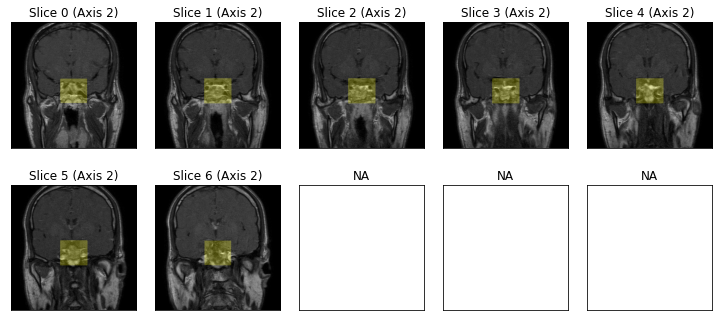

In [13]:
im_arr  = sitk2np(im)
lbl_arr = sitk2np(lbl)

viz_anno(im_arr, lbl_arr)

# Save Mesh Labels as Nii

In [14]:
def get_stem_name(fn):
    basename = os.path.basename(fn)
    return basename[:basename.index(".nii")]

for a in im_fns:
    print(get_stem_name(a))

2.25.184249200549587298191910596089011880848_t1_se_r_cor_20160926211853_7
1.3.46.670589.11.37169.5.0.7164.2016102004110442509_COR_T1_CLEAR_20161020033557_701
1.3.46.670589.11.37169.5.0.7164.2016102005322626072_COR_T1_CLEAR_20161020045705_701
1.3.46.670589.11.70769.5.0.6828.2016112311204114626_+COR_T1_THIN_SENSE_20161123104913_901
2.25.128099500521260683799022260026606955306_+Cor_T1_THIN_20161018100638_13
1.3.46.670589.11.37169.5.0.7064.2016102904242870274_COR_T1_CLEAR_20161029040301_701
1.3.46.670589.11.37169.5.0.8820.2016110101521229038_COR_T1_CLEAR_20161101012852_701
2.25.261945188120165157234217181512902374008_COR_T1_SE_20160919105232_3
1.3.46.670589.11.37169.5.0.3436.2016110300230654926_COR_T1_CLEAR_20161103000404_701
1.3.46.670589.11.42053.5.0.4772.2016110301201227714_COR_T1_CLEAR_20161103010128_801
1.3.46.670589.11.42001.5.0.5556.2016110816312576639_COR_T1_CLEAR_20161108160627_801
2.25.146054966958629375559310130923372327960_COR_T1_THIN_20160929162220_1401
1.3.46.670589.11.37169.

In [25]:
i = 0

for im_fn, lbl_fn in all_filenames:
    if i < 154:
        i = i+1
        continue
        
    is_loni = i < len(loni_filenames)
    
    # Read in fns
    im         = sitk.ReadImage(im_fn, sitk.sitkFloat32)
    lbl_mesh   = meshio.read(lbl_fn)

    # Mesh -> boolean array (Delauney triangulation)
    dims    = im.GetSize()
    aff     = make_affine(im, ras_adj=False)
    idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
    physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 
    
    lbl_arr = (Delaunay(lbl_mesh.points).find_simplex(physical_pts) >= 0).reshape(dims)

    # Boolean arr -> SITK w/ same 
    lbl = sitk.GetImageFromArray(np.swapaxes(lbl_arr.astype(np.uint8), 0, 2))
    lbl.SetOrigin(im.GetOrigin())
    lbl.SetSpacing(im.GetSpacing())   
    lbl.SetDirection(im.GetDirection())
    
    # Re-orient to LAS
    im = sitk.DICOMOrient(im, "LAS")
    lbl = sitk.DICOMOrient(lbl, "LAS")
    
    # Save as .nii
    basename = get_stem_name(im_fn)
    
    if is_loni:
        fn_stem = root + 'pitmri/las_nii/loni_'
    else:
        fn_stem = root + 'pitmri/las_nii/pit_'
        
    writer = sitk.ImageFileWriter()
    writer.SetFileName(fn_stem + 'im_' + basename + '.nii')
    writer.Execute(im)
    
    writer.SetFileName(fn_stem + 'lbl_' + basename + '.nii')
    writer.Execute(lbl)
                             
    # Save as pytorch tensor
#     lbl_pt = sitk2torch(lbl)
#     im_pt  = sitk2torch(im)
    
#     basename = get_stem_name(im_fn)
#     torch.save(im_pt, root + 'pitmri/loni_dset/im_' + basename + '.pt')
#     torch.save(lbl_pt, root + 'pitmri/loni_dset/lbl_' + basename + '.pt')
    
    # Counter
    #print(f"Done {i}")
    i += 1

In [21]:
# fns = list(os.listdir(root + "pitmri/" + "las_nii/"))
# print(fns[0], "loni_" + fns[0])

# for fn in fns:
#     os.rename(root + "pitmri/" + "las_nii/" + fn, root + "pitmri/" + "las_nii/" + "loni_" + fn)

lbl_ABIDE_50056_MRI_MP-RAGE_br_raw_20120830214830883_S165198_I329208.nii loni_lbl_ABIDE_50056_MRI_MP-RAGE_br_raw_20120830214830883_S165198_I329208.nii


In [16]:
len(loni_filenames)

337

In [ ]:
# Save nii fnames

all_filenames_nii = []
for i, (im_fn, lbl_fn) in enumerate(all_filenames):
    basename = get_stem_name(im_fn)
    
    is_loni = i < len(loni_filenames)
    
    if is_loni:
        fn_stem = root + 'pitmri/las_nii/loni_'
    else:
        fn_stem = root + 'pitmri/las_nii/pit_'
        
    im = fn_stem + 'im_' + basename + '.nii'
    lbl = fn_stem + 'lbl_' + basename + '.nii'
    
    all_filenames_nii.append((im, lbl))
    
print("N = ", len(all_filenames_nii))

# for fn in all_filenames_nii:
#     print(fn)

# Save
with open(root + 'pitmri/' + 'all_filenames_nii.pkl', 'wb') as f:
    pickle.dump(all_filenames_nii, f)

In [17]:
# Get Labels
with open(root + 'pitmri/' + 'all_filenames.pkl', 'rb') as f: 
    all_filenames = pickle.load(f)

In [19]:
# Save nii fnames

all_filenames_pt = []
for im_fn, lbl_fn in all_filenames:
    basename = get_stem_name(im_fn)
    im_fn_pt  = root + 'pitmri/dset/im_' + basename + '.pt'
    lbl_fn_pt = root + 'pitmri/dset/lbl_' + basename + '.pt'
    
    all_filenames_pt.append((im_fn_pt, lbl_fn_pt))
    
print("N = ", len(all_filenames_pt))


# Save
with open(root + 'pitmri/' + 'all_filenames_pt.pkl', 'wb') as f:
    pickle.dump(all_filenames_pt, f)

N =  50


In [ ]:
# Save pt fnamses

all_filenames_pt = []
for im_fn, lbl_fn in all_filenames:
    basename = get_stem_name(im_fn)
    im_fn_pt  = root + 'pitmri/dset/im_' + basename + '.pt'
    lbl_fn_pt = root + 'pitmri/dset/lbl_' + basename + '.pt'
    
    all_filenames_pt.append((im_fn_pt, lbl_fn_pt))
    
print("N = ", len(all_filenames_pt))


# Save
with open(root + 'pitmri/' + 'all_filenames_pt.pkl', 'wb') as f:
    pickle.dump(all_filenames_pt, f)

In [20]:
for im_fn, lbl_fn in all_filenames_pt:
    lbl_pt = torch.load(lbl_fn)
    print(lbl_pt.shape)

torch.Size([512, 16, 512])
torch.Size([320, 14, 320])
torch.Size([512, 18, 512])
torch.Size([512, 14, 512])
torch.Size([432, 24, 432])
torch.Size([256, 24, 256])
torch.Size([512, 17, 512])
torch.Size([256, 11, 256])
torch.Size([512, 16, 512])
torch.Size([432, 18, 432])
torch.Size([512, 18, 512])
torch.Size([512, 16, 512])
torch.Size([512, 16, 512])
torch.Size([300, 15, 384])
torch.Size([512, 16, 512])
torch.Size([336, 14, 336])
torch.Size([512, 17, 512])
torch.Size([512, 18, 512])
torch.Size([512, 16, 512])
torch.Size([576, 17, 640])
torch.Size([256, 11, 256])
torch.Size([512, 20, 512])
torch.Size([512, 18, 512])
torch.Size([512, 16, 512])
torch.Size([512, 25, 512])
torch.Size([512, 18, 512])
torch.Size([448, 14, 448])
torch.Size([336, 14, 336])
torch.Size([512, 16, 512])
torch.Size([432, 18, 432])
torch.Size([384, 13, 384])
torch.Size([512, 12, 512])
torch.Size([432, 22, 432])
torch.Size([400, 42, 400])
torch.Size([288, 20, 288])
torch.Size([512, 15, 512])
torch.Size([256, 17, 256])
t

In [21]:
# Get Labels
with open(root + 'pitmri/' + 'all_loni_filenames.pkl', 'rb') as f: 
    all_loni_filenames = pickle.load(f)
    
# Save pt fnamses

all_loni_filenames_pt = []
for im_fn, lbl_fn in all_loni_filenames:
    basename = get_stem_name(im_fn)
    im_fn_pt  = root + 'pitmri/loni_dset/im_' + basename + '.pt'
    lbl_fn_pt = root + 'pitmri/loni_dset/lbl_' + basename + '.pt'
    
    all_loni_filenames_pt.append((im_fn_pt, lbl_fn_pt))
    
print("N = ", len(all_loni_filenames_pt))


# Save
with open(root + 'pitmri/' + 'all_loni_filenames_pt.pkl', 'wb') as f:
    pickle.dump(all_loni_filenames_pt, f)

N =  337


# Ref

In [ ]:
# Preprocess Helper fns
#
#  1. make_affine/segm2mask
#  2. get_isotropic
#  3. get_data_dict
#  4. folder2objs
#  5. mask2bbox / print bbox
#  6. crop thershold
#  7. resample2reference
#  8. get largest connected copmonent

# segmentation
from scipy.spatial   import Delaunay
    
# given paths, return isotropic SITK obj of nii and segm obj
def paths2objs(mr_path, segm_path, ras_adj = False):
    mr         = sitk.ReadImage(mr_path, sitk.sitkFloat32)
    segm       = meshio.read(segm_path)
    mask_arr   = seg2mask(mr, segm, ras_adj)
    
    return mr, mask2sitk(mask_arr, mr)


# Convert segmentation object to numpy binary mask
# 1. Get affine matrix in SITK (aff tfm: idx coord => physical space coord)
# 2. Convert image idxs to physical coords
# 3. Check whether physical coords are in the Delauney triangulation of segmented mesh points

# 1. Get affine matrix in SITK
# https://niftynet.readthedocs.io/en/v0.2.2/_modules/niftynet/io/simple_itk_as_nibabel.html
def make_affine(simpleITKImage, ras_adj):
    # get affine transform in LPS
    c = [simpleITKImage.TransformIndexToPhysicalPoint(p)
         for p in ((1, 0, 0),
                   (0, 1, 0),
                   (0, 0, 1),
                   (0, 0, 0))]
    c = np.array(c)
    affine = np.concatenate([
        np.concatenate([c[0:3] - c[3:], c[3:]], axis=0),
        [[0.], [0.], [0.], [1.]]
    ], axis=1)
    affine = np.transpose(affine)
    # convert to RAS to match nibabel
    if ras_adj:
        affine = np.matmul(np.diag([-1., -1., 1., 1.]), affine)
    return affine

# Seg2mask
def seg2mask(image_obj, segm_obj, ras_adj):
    dims = image_obj.GetSize()
    aff     = make_affine(image_obj, ras_adj)
    idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
    physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 
    return (Delaunay(segm_obj.points).find_simplex(physical_pts) >= 0).reshape(dims)

# https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
# https://stackoverflow.com/questions/39206986/numpy-get-rectangle-area-just-the-size-of-mask/48346079
def mask2bbox(mask):

    mask = mask.astype(bool)
    
    i = np.any(mask, axis=(1, 2))
    j = np.any(mask, axis=(0, 2))
    k = np.any(mask, axis=(0, 1))

    imin, imax = np.where(i)[0][[0, -1]]
    jmin, jmax = np.where(j)[0][[0, -1]]
    kmin, kmax = np.where(k)[0][[0, -1]]

    # inclusive idxs
    return imin, imax+1, jmin, jmax+1, kmin, kmax+1

def get_bbox_size(imin, imax, jmin, jmax, kmin, kmax):
    return imax - imin, jmax-jmin, kmax-kmin

def print_bbox_size(imin, imax, jmin, jmax, kmin, kmax):
    print(f"{imax - imin}, {jmax-jmin}, {kmax-kmin}")
    
def print_bbox(imin, imax, jmin, jmax, kmin, kmax):
    print(f"Bbox coords: ({imin}, {jmin}, {kmin}) to ({imax}, {jmax}, {kmax}). Size: {imax - imin}, {jmax-jmin}, {kmax-kmin}.")
    print(f"Bounding box coord: from location ({jmin}, {kmin}) of slice {imin} to location ({jmax}, {kmax}) of slice {imax}.")
    #print(f"Slices: {imin}, {imax} ({imax-imin}), Rows: {jmin}, {jmax} ({jmax-jmin}), Cols: {kmin}, {kmax} ({kmax-kmin}).")
        

def get_bbox_vals(i,j,k):
    imin, imax = torch.where(i)[0][[0, -1]]
    jmin, jmax = torch.where(j)[0][[0, -1]]
    kmin, kmax = torch.where(k)[0][[0, -1]]
    
    # inclusive indices
    return torch.tensor([imin, imax+1, jmin, jmax+1, kmin, kmax+1])

def torch_mask2bbox(mask):
    k = torch.any(torch.any(mask, dim=0), dim=0) # 0 -> 1,2 -> 1 -> 2 left
    j = torch.any(torch.any(mask, dim=0), dim=1) # 0 -> 1,2 -> 2 -> 1 left
    i = torch.any(torch.any(mask, dim=1), dim=1) # 1 -> 0,2 -> 0 -> 0 left
    return get_bbox_vals(i,j,k)
        
def batch_get_bbox(yb, preds=False):
    # BCDHW => BDHW, assumed C
    if preds:
        masks = torch.argmax(yb, dim=1).byte()
    else:
        masks =yb.squeeze(1).byte()
    
    # batchwise BDHW
    # BDHW -> BHW -> BW
    # BDHW -> BHW -> BH
    # BDHW -> BDW -> BD 
    bk = torch.any(torch.any(masks, dim=1), dim=1) # 0 -> 1,2 -> 1 -> 2 left
    bj = torch.any(torch.any(masks, dim=1), dim=2) # 0 -> 1,2 -> 2 -> 1 left
    bi = torch.any(torch.any(masks, dim=2), dim=2) # 1 -> 0,2 -> 0 -> 0 left

    # for b in batch
    return torch.stack([get_bbox_vals(i,j,k) for i,j,k in zip(bi,bj,bk)], dim=0)



In [ ]:

def print_hardware_stats():
    # print GPU/CPU counts
    gpu_count = torch.cuda.device_count()
    cpu_count = os.cpu_count()
    print("#GPU = {0:d}, #CPU = {1:d}".format(gpu_count, cpu_count))

    # print GPU stats
    GPUs = GPU.getGPUs()
    for gpu in GPUs:
        print("GPU {0:20s} RAM Free: {1:.0f}MB | Used: {2:.0f}MB | Util {3:3.0f}% | Total {4:.0f}MB".format(gpu.name, gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# sitk obj and np array have different index conventions
# deep copy
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)

# numpy mask arr into sitk obj
def mask2sitk(mask_arr, sitk_image):
  # convert bool mask to int mask
  # swap axes for sitk
  obj = sitk.GetImageFromArray(np.swapaxes(mask_arr.astype(np.uint8), 0, 2))
  obj.SetOrigin(sitk_image.GetOrigin())
  obj.SetSpacing(sitk_image.GetSpacing())   
  obj.SetDirection(sitk_image.GetDirection())
  return obj

def print_sitk_info(image):    
    print("Size: ", image.GetSize())
    print("Origin: ", image.GetOrigin())
    print("Spacing: ", image.GetSpacing())
    print("Direction: ", image.GetDirection())
    print(f"Pixel type: {image.GetPixelIDValue()} = {image.GetPixelIDTypeAsString()}")


In [ ]:
# plot

from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.viz import *